# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [76]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker_gaussian_process import plot_maker_3d

## 2. Importing Data

In [102]:
# get all the red ball data
X_butterfly_a = pd.read_csv('../data-7cam-10/data-butterfly/red_ball_coordinates_128px_2024-03-12_22h20m.csv', decimal='.', delimiter=',')
X_butterfly_b = pd.read_csv('../data-7cam-10/data-butterfly/red_ball_coordinates_128px_2024-03-12_22h22m.csv', decimal='.', delimiter=',')
X_butterfly_c = pd.read_csv('../data-7cam-10/data-butterfly/red_ball_coordinates_128px_2024-03-12_22h23m.csv', decimal='.', delimiter=',')
X_spiral_a = pd.read_csv('../data-7cam-10/data-spiral/red_ball_coordinates_128px_2024-03-12_22h25m.csv', decimal='.', delimiter=',')
X_spiral_b = pd.read_csv('../data-7cam-10/data-spiral/red_ball_coordinates_128px_2024-03-12_22h27m.csv', decimal='.', delimiter=',')
X_spiral_c = pd.read_csv('../data-7cam-10/data-spiral/red_ball_coordinates_128px_2024-03-12_22h28m.csv', decimal='.', delimiter=',')
X_spirograph_a = pd.read_csv('../data-7cam-10/data-spirograph/red_ball_coordinates_128px_2024-03-12_22h31m.csv', decimal='.', delimiter=',')
X_spirograph_b = pd.read_csv('../data-7cam-10/data-spirograph/red_ball_coordinates_128px_2024-03-12_22h32m.csv', decimal='.', delimiter=',')
X_spirograph_c = pd.read_csv('../data-7cam-10/data-spirograph/red_ball_coordinates_128px_2024-03-12_22h33m.csv', decimal='.', delimiter=',')
X_circle_a = pd.read_csv('../data-7cam-10/data-circle/red_ball_coordinates_128px_2024-03-12_22h35m.csv', decimal='.', delimiter=',')
X_circle_b = pd.read_csv('../data-7cam-10/data-circle/red_ball_coordinates_128px_2024-03-12_22h36m.csv', decimal='.', delimiter=',')
X_circle_c = pd.read_csv('../data-7cam-10/data-circle/red_ball_coordinates_128px_2024-03-12_22h37m.csv', decimal='.', delimiter=',')
X_lissajous_a = pd.read_csv('../data-7cam-10/data-lis-curve/red_ball_coordinates_128px_2024-03-12_22h46m.csv', decimal='.', delimiter=',')
X_lissajous_b = pd.read_csv('../data-7cam-10/data-lis-curve/red_ball_coordinates_128px_2024-03-12_22h47m.csv', decimal='.', delimiter=',')
X_lissajous_c = pd.read_csv('../data-7cam-10/data-lis-curve/red_ball_coordinates_128px_2024-03-12_22h49m.csv', decimal='.', delimiter=',')
X_random_a = pd.read_csv('../data-7cam-10/data-rand/red_ball_coordinates_128px_2024-03-12_22h18m.csv', decimal='.', delimiter=',')

In [103]:
# get all the position data
y_butterfly_a = pd.read_csv('../data-7cam-10/data-butterfly/positions_xyz_2024-03-12_22h20m.csv', decimal='.', delimiter=',').iloc[4:]
y_butterfly_b = pd.read_csv('../data-7cam-10/data-butterfly/positions_xyz_2024-03-12_22h22m.csv', decimal='.', delimiter=',').iloc[4:]   
y_butterfly_c = pd.read_csv('../data-7cam-10/data-butterfly/positions_xyz_2024-03-12_22h23m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_a = pd.read_csv('../data-7cam-10/data-spiral/positions_xyz_2024-03-12_22h25m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_b = pd.read_csv('../data-7cam-10/data-spiral/positions_xyz_2024-03-12_22h27m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_c = pd.read_csv('../data-7cam-10/data-spiral/positions_xyz_2024-03-12_22h28m.csv', decimal='.', delimiter=',').iloc[4:]
y_spirograph_a = pd.read_csv('../data-7cam-10/data-spirograph/positions_xyz_2024-03-12_22h31m.csv', decimal='.', delimiter=',').iloc[4:]
y_spirograph_b = pd.read_csv('../data-7cam-10/data-spirograph/positions_xyz_2024-03-12_22h32m.csv', decimal='.', delimiter=',').iloc[4:]
y_spirograph_c = pd.read_csv('../data-7cam-10/data-spirograph/positions_xyz_2024-03-12_22h33m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_a = pd.read_csv('../data-7cam-10/data-circle/positions_xyz_2024-03-12_22h35m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_b = pd.read_csv('../data-7cam-10/data-circle/positions_xyz_2024-03-12_22h36m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_c = pd.read_csv('../data-7cam-10/data-circle/positions_xyz_2024-03-12_22h37m.csv', decimal='.', delimiter=',').iloc[4:]
y_lissajous_a = pd.read_csv('../data-7cam-10/data-lis-curve/positions_xyz_2024-03-12_22h46m.csv', decimal='.', delimiter=',').iloc[4:]
y_lissajous_b = pd.read_csv('../data-7cam-10/data-lis-curve/positions_xyz_2024-03-12_22h47m.csv', decimal='.', delimiter=',').iloc[4:]
y_lissajous_c = pd.read_csv('../data-7cam-10/data-lis-curve/positions_xyz_2024-03-12_22h49m.csv', decimal='.', delimiter=',').iloc[4:]
y_random_a = pd.read_csv('../data-7cam-10/data-rand/positions_xyz_2024-03-12_22h18m.csv', decimal='.', delimiter=',').iloc[4:]

#### 2.1 Check for Missing Values in spriral_down_b and spiral_down_c

In [79]:
print(f'The amount of NaN values in X_butterfly_a: {X_butterfly_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_butterfly_b: {X_butterfly_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_butterfly_c: {X_butterfly_c.isna().sum().sum()}')
print(f'The amount of NaN values in X_spiral_a: {X_spiral_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_spiral_b: {X_spiral_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_spiral_c: {X_spiral_c.isna().sum().sum()}')
print(f'The amount of NaN values in X_spirograph_a: {X_spirograph_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_spirograph_b: {X_spirograph_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_spirograph_c: {X_spirograph_c.isna().sum().sum()}')
print(f'The amount of NaN values in X_circle_a: {X_circle_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_circle_b: {X_circle_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_circle_c: {X_circle_c.isna().sum().sum()}')
print(f'The amount of NaN values in X_lissajous_a: {X_lissajous_a.isna().sum().sum()}')
print(f'The amount of NaN values in X_lissajous_b: {X_lissajous_b.isna().sum().sum()}')
print(f'The amount of NaN values in X_lissajous_c: {X_lissajous_c.isna().sum().sum()}')
#print(f'The amount of NaN values in X_random_a: {X_random_a.isna().sum().sum()}')

The amount of NaN values in X_butterfly_a: 254
The amount of NaN values in X_butterfly_b: 1776
The amount of NaN values in X_butterfly_c: 4
The amount of NaN values in X_spiral_a: 0
The amount of NaN values in X_spiral_b: 0
The amount of NaN values in X_spiral_c: 0
The amount of NaN values in X_spirograph_a: 2
The amount of NaN values in X_spirograph_b: 1040
The amount of NaN values in X_spirograph_c: 2
The amount of NaN values in X_circle_a: 0
The amount of NaN values in X_circle_b: 2
The amount of NaN values in X_circle_c: 1006
The amount of NaN values in X_lissajous_a: 0
The amount of NaN values in X_lissajous_b: 16
The amount of NaN values in X_lissajous_c: 4


I Interpolated the files with a lot of missing values
All the results are quite good except butterfly_b 

### 2.3 Combine all the datasets

In [80]:
X_train = pd.concat([X_butterfly_a, X_butterfly_b, X_butterfly_c, X_spiral_a, X_spiral_b, X_spiral_c, X_spirograph_a, X_spirograph_b, X_spirograph_c, X_circle_a, X_circle_b, X_circle_c, X_lissajous_a, X_lissajous_b, X_lissajous_c ])#,  X_random_a])
y_train = pd.concat([y_butterfly_a, y_butterfly_b, y_butterfly_c, y_spiral_a, y_spiral_b, y_spiral_c, y_spirograph_a, y_spirograph_b, y_spirograph_c, y_circle_a, y_circle_b, y_circle_c, y_lissajous_a, y_lissajous_b, y_lissajous_c])#, y_random_a])
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [81]:
X_train.shape, y_train.shape

((14539, 14), (14539, 3))

In [82]:
combined = pd.concat([X_train, y_train], axis=1)

## 3. Data Preprocessing

In [83]:
# check for missing values
print(f'The data has missing values: {combined.isnull().sum().sum()}')
combined.dropna(inplace=True)
print(f'The data has missing values: {combined.isnull().sum().sum()}')

The data has missing values: 4106
The data has missing values: 0


In [105]:
X = combined.iloc[:, :14]
y = combined.iloc[:, 14:]
X.to_csv('../data-7cam-10/all/red_ball_all.csv', index=False)
y.to_csv('../data-7cam-10/all/positions_all.csv', index=False)

In [85]:
X.shape, y.shape

((13835, 14), (13835, 3))

In [86]:
# scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter Tuning

In [87]:
# create a pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(random_state=42))
])

In [88]:
param_grid = {
    'mlp__hidden_layer_sizes': 
        [(50, 100, 50) # ,(100,), (64, 32, 64)],
         ],
    'mlp__activation': ['identity', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [10000, 20000, 28000],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__early_stopping': [True],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, n_iter=100, n_jobs=-1, verbose=3, random_state=42)

random_search.fit(X_scaled, y_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('mlp',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'mlp__activation': ['identity', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.001, 0.01, 0.1],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50, 100,
                                                                     50)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [10000, 20000, 28000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=42, verbose=3)

In [89]:
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_}')

Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 20000, 'mlp__learning_rate_init': 0.001, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (50, 100, 50), 'mlp__early_stopping': True, 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}
Best score: 0.8732709898458377


In [90]:
model = random_search.best_estimator_

## 5. Training the Model

In [91]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(activation='tanh', alpha=0.01,
                              early_stopping=True,
                              hidden_layer_sizes=(50, 100, 50),
                              learning_rate='adaptive', max_iter=20000,
                              random_state=42))])

## 6. Make Predictions On Test Data

In [92]:
import pandas as pd

In [93]:
X_test_8_a = pd.read_csv('../data-7cam-10/data-8motion/red_ball_coordinates_128px_2024-03-12_22h40m.csv', decimal='.', delimiter=',')
X_test_8_b = pd.read_csv('../data-7cam-10/data-8motion/red_ball_coordinates_128px_2024-03-12_22h41m.csv', decimal='.', delimiter=',')
X_test_8_c = pd.read_csv('../data-7cam-10/data-8motion/red_ball_coordinates_128px_2024-03-12_22h42m.csv', decimal='.', delimiter=',')

In [94]:
y_test_8_a = pd.read_csv('../data-7cam-10/data-8motion/positions_xyz_2024-03-12_22h40m.csv', decimal='.', delimiter=',').iloc[4:]
y_test_8_b = pd.read_csv('../data-7cam-10/data-8motion/positions_xyz_2024-03-12_22h41m.csv', decimal='.', delimiter=',').iloc[4:]
y_test_8_c = pd.read_csv('../data-7cam-10/data-8motion/positions_xyz_2024-03-12_22h42m.csv', decimal='.', delimiter=',').iloc[4:]

In [95]:
X_test_chaos = pd.read_csv('../data-7cam-10/data-chaos/red_ball_coordinates_128px_2024-03-12_22h16m.csv', decimal='.', delimiter=',')
y_test_chaos = pd.read_csv('../data-7cam-10/data-chaos/positions_xyz_2024-03-12_22h16m.csv', decimal='.', delimiter=',').iloc[4:]

In [96]:
def prepare_and_scale_test_data(X_test_val, y_test_val, scaler_x_test):
    y_test_val = y_test_val.iloc[4:]
    combined_test = pd.concat([X_test_val, y_test_val], axis=1)
    combined_test.dropna(inplace=True)
    X_val = combined_test.iloc[:, :14]
    y_val = combined_test.iloc[:, 14:]
    X_scaled_test = scaler_x_test.transform(X_val)
    return X_scaled_test, y_val

In [97]:
def predict_evaluate_plot(X_test_val_scaled, y_test_val, nn_model, scaler_y_test, title='Trajectory of Ball in 3D Space'):
    y_test_predicted_scaled = nn_model.predict(X_test_val_scaled)
    y_test_pred = scaler_y_test.inverse_transform(y_test_predicted_scaled)
    mse, mae, r2 = evaluate_model(y_test_val, y_test_pred, 'Test Data')
    # change col 1 and 2 from place, so it corresponds to the unity 3d space
    y_test_pred = y_test_pred[:, [0, 2, 1]]
    y_test_val = y_test_val.to_numpy()[:, [0, 2, 1]]
    plot_maker_3d(y_test_val, y_test_pred, title)
    return y_test_pred, mse, mae, r2

Mean Squared Error on Test Data Set: 0.2144438820644248
Mean Absolute Error on Test Data Set: 0.374353753313369
R2 Score on Test Data set: 0.5414680672997855


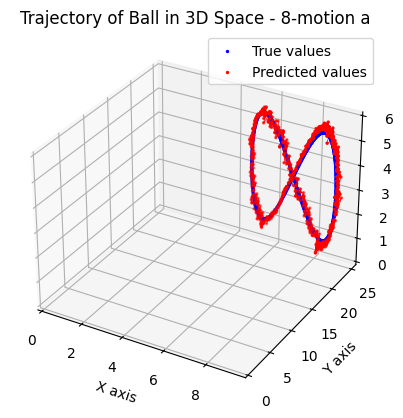

In [98]:
X_test_8_scaled_a, y_test_8_a = prepare_and_scale_test_data(X_test_8_a, y_test_8_a, scaler_x)
X_test_8_pred_a, mse_8_a, mae_8_a, r2_8_a = predict_evaluate_plot(X_test_8_scaled_a, y_test_8_a, model, scaler_y, title='Trajectory of Ball in 3D Space - 8-motion a')

Mean Squared Error on Test Data Set: 0.2070246594362721
Mean Absolute Error on Test Data Set: 0.3306229864023546
R2 Score on Test Data set: 0.8599524607518991


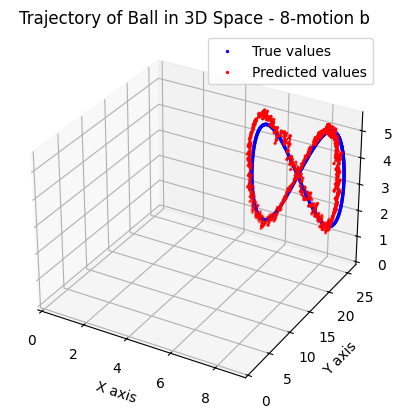

In [99]:
X_test_8_scaled_b, y_test_8_b = prepare_and_scale_test_data(X_test_8_b, y_test_8_b, scaler_x)
X_test_8_pred_b, mse_8_b, mae_8_b, r2_8_b = predict_evaluate_plot(X_test_8_scaled_b, y_test_8_b, model, scaler_y, title='Trajectory of Ball in 3D Space - 8-motion b')

Mean Squared Error on Test Data Set: 0.20101925916459776
Mean Absolute Error on Test Data Set: 0.28595177201208943
R2 Score on Test Data set: -1.445666307220319e+28


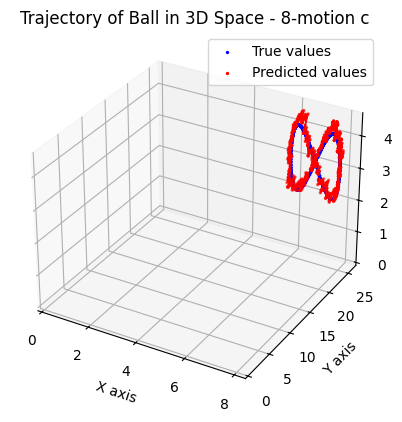

In [100]:
X_test_8_scaled_c, y_test_8_c = prepare_and_scale_test_data(X_test_8_c, y_test_8_c, scaler_x)
X_test_8_pred_c, mse_8_c, mae_8_c, r2_8_c = predict_evaluate_plot(X_test_8_scaled_c, y_test_8_c, model, scaler_y, title='Trajectory of Ball in 3D Space - 8-motion c')